In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stripROtools




# UH DLC Micromegas - xHyL

In [36]:
# Location of data
file_loc = ["/Users/majdghrear/data/VMM3a_SRS/AUG23/UH_DLC/Po210/540Vmesh_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1500_dp_400_cr_0p20-2p00_coin_center-of-mass_test.root", "/Users/majdghrear/data/VMM3a_SRS/AUG23/UH_DLC/Po210/540Vmesh_2_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1500_dp_400_cr_0p20-2p00_coin_center-of-mass_test.root"]

# Create pandas data frame of the cluster info
df_cluster = stripROtools.read_root(file_loc, clusters=True, hits=False)

# Define additional columns

# number of hits
df_cluster["nhits"]=df_cluster.apply(lambda row: len(row.strips0)+len(row.strips1) ,axis=1)

df_cluster["electrons_x"] = df_cluster.adc0.apply(lambda x: 6240 * ( x  / 9.0 ) ) # 9 mV/fC is VMM gain setting for x channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
df_cluster["electrons_y"] = df_cluster.adc1.apply(lambda x: 6240 * ( x / 4.5 ) ) # 4.5 mV/fC is VMM gain setting for y channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
df_cluster["electrons"] = df_cluster.electrons_x + df_cluster.electrons_y

# length on x/y plane
df_cluster["L"]=np.sqrt((df_cluster.strips0.apply(np.max) - df_cluster.strips0.apply(np.min))**2 + (df_cluster.strips1.apply(np.max) - df_cluster.strips1.apply(np.min))**2)

# time range on x strips
df_cluster["TR0"] = df_cluster.times1.apply(np.max)-df_cluster.times1.apply(np.min)

# time range on y strips
df_cluster["TR1"] = df_cluster.times1.apply(np.max)-df_cluster.times1.apply(np.min)

#fiducialize
df_cluster = stripROtools.fiducializeVMM(df_cluster, n_vmm_x=5, n_vmm_y=10, min_hits=5)

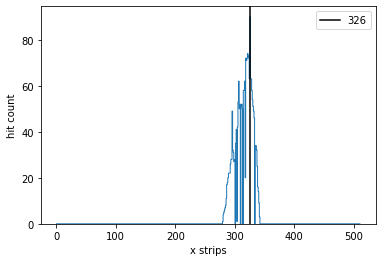

In [37]:
strip_edges = np.arange(-0.5,512.5,1.0)

plt.figure()
n,bins,patches = plt.hist(np.concatenate(df_cluster.strips0),bins=strip_edges,histtype='step')
bin_centers = (bins+(bins+1))/2
plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
plt.xlabel("x strips")
plt.ylabel("hit count")
plt.legend()

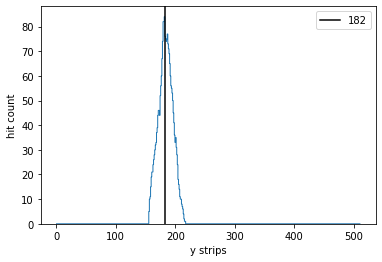

In [38]:
plt.figure()
n,bins,patches = plt.hist(np.concatenate(df_cluster.strips1),bins=strip_edges,histtype='step')
bin_centers = (bins+(bins+1))/2
plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
plt.xlabel("y strips")
plt.ylabel("hit count")
plt.legend()

Text(0, 0.5, 'hit count')

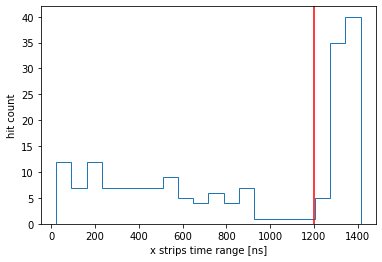

In [39]:
plt.figure()
plt.hist(df_cluster["TR0"],bins=20,histtype='step')
plt.axvline(1200, color='r')
plt.xlabel("x strips time range [ns]")
plt.ylabel("hit count")

Text(0, 0.5, 'hit count')

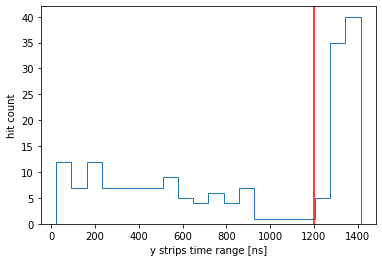

In [40]:
plt.figure()
plt.hist(df_cluster["TR1"],bins=20,histtype='step')
plt.axvline(1200, color='r')
plt.xlabel("y strips time range [ns]")
plt.ylabel("hit count")

Text(0, 0.5, 'count')

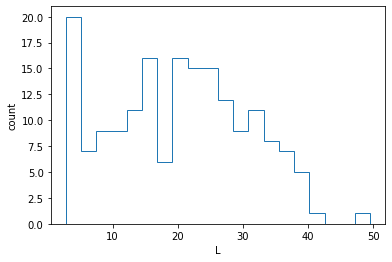

In [41]:
#Plot ADC x distribution
plt.hist(df_cluster.L, bins = 20, histtype="step")
plt.xlabel("L")
plt.ylabel("count")

Text(0, 0.5, 'count')

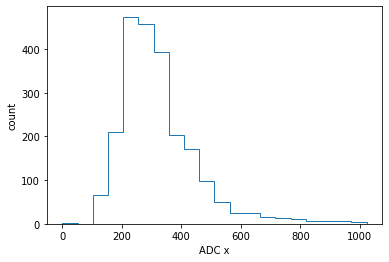

In [42]:
#Plot ADC x distribution
plt.hist(np.concatenate(df_cluster.adcs0), bins=20, histtype="step")
plt.xlabel("ADC x")
plt.ylabel("count")

Text(0, 0.5, 'count')

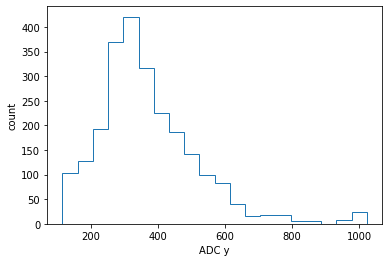

In [43]:
#Plot ADC y distribution
plt.hist(np.concatenate(df_cluster.adcs1), bins=20, histtype="step")
plt.xlabel("ADC y")
plt.ylabel("count")

Text(0, 0.5, 'count')

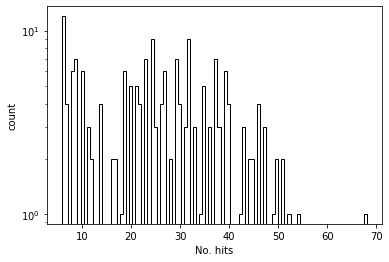

In [44]:
plt.figure()
plt.hist(df_cluster["nhits"],bins=100,histtype='step',color='k')
plt.yscale("log")
plt.xlabel("No. hits")
plt.ylabel("count")

In [45]:
# Isolate events 
df_cut = df_cluster.loc[ (df_cluster.TR0 > 1200) & (df_cluster.TR1 > 1200) & (df_cluster.nhits > 8) & (df_cluster.L <= 28) ]
df_cut=df_cut.reset_index(drop=True)
len(df_cut)

49

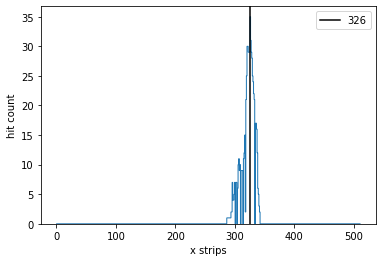

In [46]:
strip_edges = np.arange(-0.5,512.5,1.0)

plt.figure()
n,bins,patches = plt.hist(np.concatenate(df_cut.strips0),bins=strip_edges,histtype='step')
bin_centers = (bins+(bins+1))/2
plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
plt.xlabel("x strips")
plt.ylabel("hit count")
plt.legend()

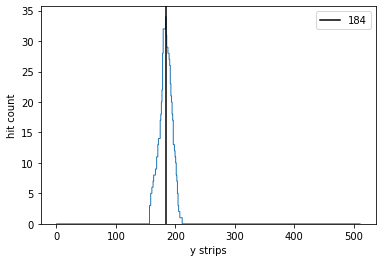

In [47]:
plt.figure()
n,bins,patches = plt.hist(np.concatenate(df_cut.strips1),bins=strip_edges,histtype='step')
bin_centers = (bins+(bins+1))/2
plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
plt.xlabel("y strips")
plt.ylabel("hit count")
plt.legend()

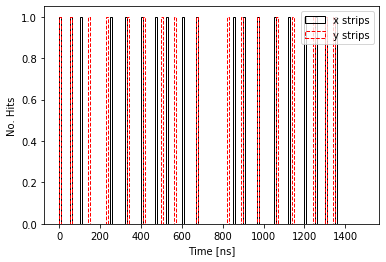

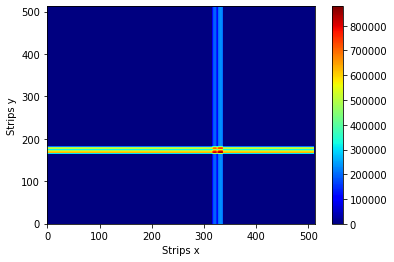

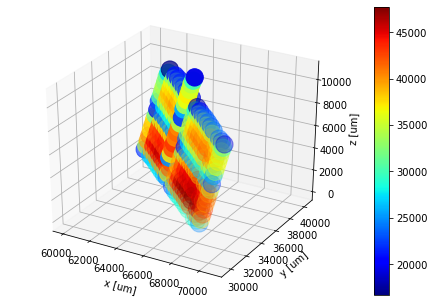

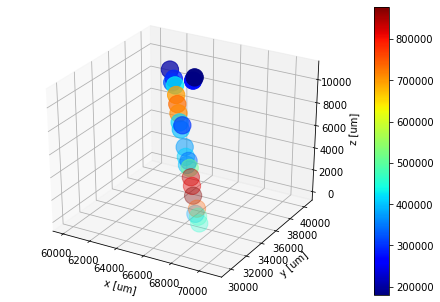

In [65]:
test_event = df_cut.iloc[30]

dsp = stripROtools.TrackTools(event = test_event, gain_x=9, gain_y=4.5, v_drift=8.0)

# Plot 1D time display
dsp.TimeHistView(t_max = 1500, t_bin = 10)

# Plot 2D display
dsp.Strip2DView(fullview = True)

# Plot 3D display
dsp.Reconst3D_v0()
x,y,z,c = dsp.Reconst3D_v1( mu = -7.5, sigma = 16.5 , n_sigma = 3)

In [28]:
def get_ErrVecs(track):

    # 3D reconst for x,y,z,c 
    dsp = stripROtools.TrackTools(event = track, gain_x=4.5, gain_y=4.5)
    x_vals,y_vals,z_vals,charges = dsp.Reconst3D_v1(plot=False)

    X = np.array([x_vals,y_vals,z_vals]).T

    # 1) Center on barycenter
    # Barycenter is the charge-weighted mean position
    x_b = np.sum(X*(charges.reshape(len(charges),1)),axis=0)/np.sum(charges)
    # Shift data to barycenter
    X = X-x_b

    # 2) Find principle axis
    # Use charges for weights
    W = charges.reshape(len(charges),1)
    # Compute weighted covariance matrix
    WCM = ( (W*X).T @ X ) / np.sum(W)
    U1,S1,D1 =  np.linalg.svd(WCM)
    v_PA = np.array([D1[0][0],D1[0][1],D1[0][2]])

    # projection of mean-centered position onto principle axis
    proj = np.array([(X@v_PA)*v_PA[0],(X@v_PA)*v_PA[1],(X@v_PA)*v_PA[2]]).T

    # Mismeasurement vectors
    # The distribution of the x and y values gives us sigma x and sigma y
    err =X-proj

    return x_vals,y_vals,z_vals,charges,v_PA,x_b
    

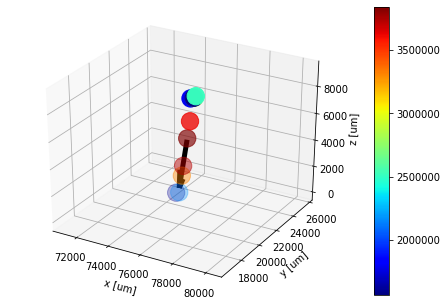

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

x_vals,y_vals,z_vals,weights,direction,start = get_ErrVecs(test_event)
direction = 5000*direction

# Plot the 3D scatter
fig = plt.figure()
ax = Axes3D(fig)

#set color map
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=min(weights), vmax=max(weights))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
                
ax.scatter(x_vals, y_vals, z_vals, c=scalarMap.to_rgba(weights),s=300)
ax.quiver(start[0],start[1],start[2],direction[0],direction[1],direction[2], linewidths=5, color = 'k')
scalarMap.set_array(weights)
fig.colorbar(scalarMap)

# Force all axis to have equal limits
extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
sz = extents[:,1] - extents[:,0]
centers = np.mean(extents, axis=1)
maxsize = max(abs(sz))
r = maxsize/2
for ctr, dim in zip(centers, 'xyz'):
    getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

# Set labels
ax.set_xlabel('x [um]')
ax.set_ylabel('y [um]')
ax.set_zlabel('z [um]')
                
plt.show()